In [1]:
import string
import random
from random import randint
import cv2
import numpy as np
import os
from PIL import Image, ImageFont, ImageDraw
import matplotlib.pyplot as plt
import math

## Generating Data For NN

In [2]:
path = "./"
!rm -rf "./pictures"
!rm -rf "./blurred_pictures"
!mkdir pictures
!mkdir blurred_pictures

NUMBER_OF_PLATES = 10000

for i in range(0, NUMBER_OF_PLATES):

    # Pick two random letters
    plate_alpha = ""
    for _ in range(0, 2):
        plate_alpha += (random.choice(string.ascii_uppercase))

    # Pick two random numbers
    num = randint(0, 99)
    plate_num = "{:02d}".format(num)

    # Write plate to image
    blank_plate = cv2.imread(path+'blank_plate.png')

    # Convert into a PIL image (this is so we can use the monospaced fonts)
    blank_plate_pil = Image.fromarray(blank_plate)

    # Get a drawing context
    draw = ImageDraw.Draw(blank_plate_pil)
    monospace = ImageFont.truetype("/usr/share/fonts/truetype/ubuntu/UbuntuMono-R.ttf", 200)
    draw.text(xy=(48, 75),
              text=plate_alpha + " " + plate_num, 
              fill=(255,0,0), font=monospace)

    # Convert back to OpenCV image and save
    blank_plate = np.array(blank_plate_pil)
    resized = cv2.resize(blank_plate, (300,80))

    # Write license plate to file
    cv2.imwrite(os.path.join(path + "pictures/", 
                             "plate_{}{}.png".format(plate_alpha, plate_num)),
                             resized)

In [13]:
PATH = "./pictures/"
labels = os.listdir(PATH)
print(len(labels))

9288


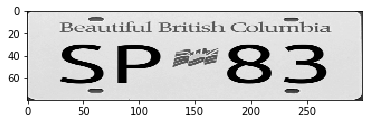

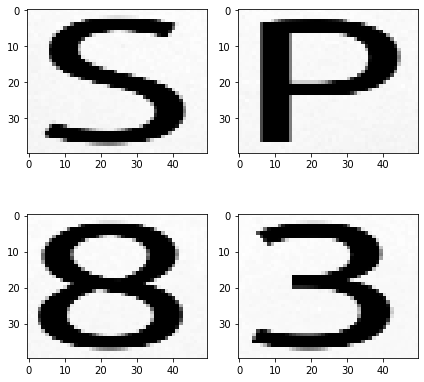

In [14]:
img = cv2.cvtColor(cv2.imread(f"./pictures/{labels[0]}"), cv2.COLOR_BGR2GRAY)
# img = cv2.GaussianBlur(img, (31,31), 0)

x0,y,w,h = 25, 28, 50, 40
x1 = 75
x2 = 176
x3 = 226
plt.imshow(img, cmap='gray')
characters = []
characters.append(img[y:y+h, x0:x0+w])
characters.append(img[y:y+h, x1:x1+w])
characters.append(img[y:y+h, x2:x2+w])
characters.append(img[y:y+h, x3:x3+w])

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
# Plot the smaller images in the remaining subplots
for i, ax in enumerate(axs.flatten()):
    ax.imshow(characters[i], cmap='gray')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [15]:
##Augment the data
#Blur each plate with a random kernel (1,1) to (31,31)
#size must be an odd number
for i in range(0, len(labels)):
    n = randint(0,15)
    img = cv2.cvtColor(cv2.imread(f"{PATH+labels[i]}"), cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(img, (2*n+1,2*n+1), 0)
    cv2.imwrite(os.path.join("./blurred_pictures/",labels[i]), blurred)



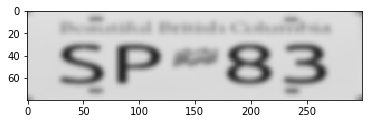

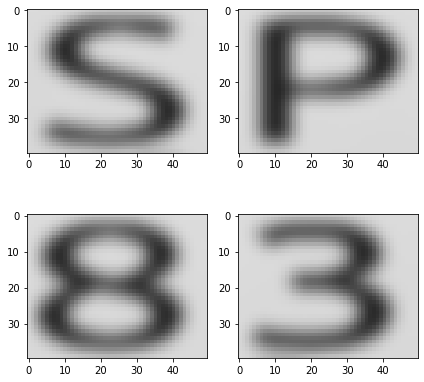

In [17]:
img = cv2.imread(f"./blurred_pictures/{labels[0]}")

x0,y,w,h = 25, 28, 50, 40
x1 = 75
x2 = 176
x3 = 226
plt.imshow(img, cmap='gray')
characters = []
characters.append(img[y:y+h, x0:x0+w])
characters.append(img[y:y+h, x1:x1+w])
characters.append(img[y:y+h, x2:x2+w])
characters.append(img[y:y+h, x3:x3+w])

# Create a 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(6, 6))
# Plot the smaller images in the remaining subplots
for i, ax in enumerate(axs.flatten()):
    ax.imshow(characters[i], cmap='gray')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()

In [18]:
data = []

for label in labels:
    img = cv2.cvtColor(cv2.imread(f"{PATH+label}"), cv2.COLOR_BGR2GRAY)
    x0,y,w,h = 25, 28, 50, 40
    x1 = 75
    x2 = 176
    x3 = 226
    CLASSES = 36

    data.append(((img[y:y+h, x0:x0+w]), np.identity(CLASSES)[ord(label[6])-65].reshape(CLASSES)))
    data.append(((img[y:y+h, x1:x1+w]), np.identity(CLASSES)[ord(label[7])-65].reshape(CLASSES)))
    data.append(((img[y:y+h, x2:x2+w]), np.identity(CLASSES)[ord(label[8])-48+26].reshape(CLASSES)))
    data.append(((img[y:y+h, x3:x3+w]), np.identity(CLASSES)[ord(label[9])-48+26].reshape(CLASSES)))

random.shuffle(data)

In [35]:
VALIDATION_SPLIT = 0.1

X_dataset = np.array([x[0] for x in data])
Y_dataset = np.array([x[1] for x in data])

split_index = math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT))

X_train_dataset = X_dataset[:split_index]
Y_train_dataset = Y_dataset[:split_index]

X_val_dataset = X_dataset[split_index:]
Y_val_dataset = Y_dataset[split_index:]

# In this case we do not define a test set.

print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))
print("Total examples: {:d}\nTraining examples: {:d}\n"
      "Validation examples: {:d}".
      format(X_dataset.shape[0],
             X_train_dataset.shape[0],
             X_val_dataset.shape[0]))

X shape: (37336, 40, 50)
Y shape: (37336, 36)
Total examples: 37336
Training examples: 33603
Validation examples: 3733


## CNN Model

In [5]:
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [6]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and 
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [7]:
# conv_model = models.Sequential()
# conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
#                              input_shape=(40, 50, 1)))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
# # conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Flatten())
# conv_model.add(layers.Dropout(0.5))
# conv_model.add(layers.Dense(512, activation='relu'))
# conv_model.add(layers.Dense(36, activation='softmax'))


conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(40, 50, 1))) #3 for bgr, 1 for grayscale 144, 256 for 20%
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax'))

In [8]:
conv_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 38, 48, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 19, 24, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 17, 22, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 11, 64)        0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 6, 9, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 3, 4, 128)        0

In [9]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(lr=LEARNING_RATE),
                   metrics=['acc'])

In [10]:
reset_weights(conv_model)

/home/fizzer/.local/lib/python3.8/site-packages/keras/initializers/initializers_v2.py:120: UserWarning: The initializer GlorotUniform is unseeded and being called multiple times, which will return identical values  each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initalizer instance more than once.
  warnings.warn(


In [42]:
history_conv = conv_model.fit(X_train_dataset, Y_train_dataset, 
                              validation_data=(X_val_dataset, Y_val_dataset), 
                              epochs=5, 
                              batch_size=16)

# We can also run the training by specifiying the validation split directly.
# history_conv = conv_model.fit(X_dataset, Y_dataset, 
                            #   validation_split=VALIDATION_SPLIT, 
#                               epochs=80, 
#                               batch_size=16)

Epoch 1/5
2101/2101 [==============================] - 27s 13ms/step - loss: 0.1427 - acc: 0.9697 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 2/5
2101/2101 [==============================] - 28s 13ms/step - loss: 0.0048 - acc: 0.9994 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 3/5
2101/2101 [==============================] - 29s 14ms/step - loss: 0.0013 - acc: 0.9998 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 4/5
2101/2101 [==============================] - 30s 14ms/step - loss: 0.0019 - acc: 0.9996 - val_loss: 0.0000e+00 - val_acc: 1.0000
Epoch 5/5
2101/2101 [==============================] - 31s 15ms/step - loss: 1.2903e-07 - acc: 1.0000 - val_loss: 0.0000e+00 - val_acc: 1.0000


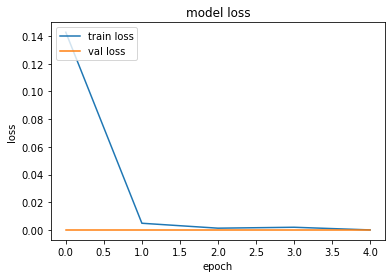

In [43]:
plt.plot(history_conv.history['loss'])
plt.plot(history_conv.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train loss', 'val loss'], loc='upper left')
plt.show()

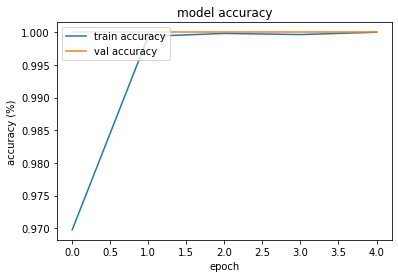

In [44]:
plt.plot(history_conv.history['acc'])
plt.plot(history_conv.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy (%)')
plt.xlabel('epoch')
plt.legend(['train accuracy', 'val accuracy'], loc='upper left')
plt.show()

In [45]:
from sklearn.metrics import ConfusionMatrixDisplay
ypred = conv_model.predict(X_val_dataset)
ypred=np.argmax(ypred, axis=1)
ytest=np.argmax(Y_val_dataset, axis=1)

117/117 [==============================] - 1s 9ms/step


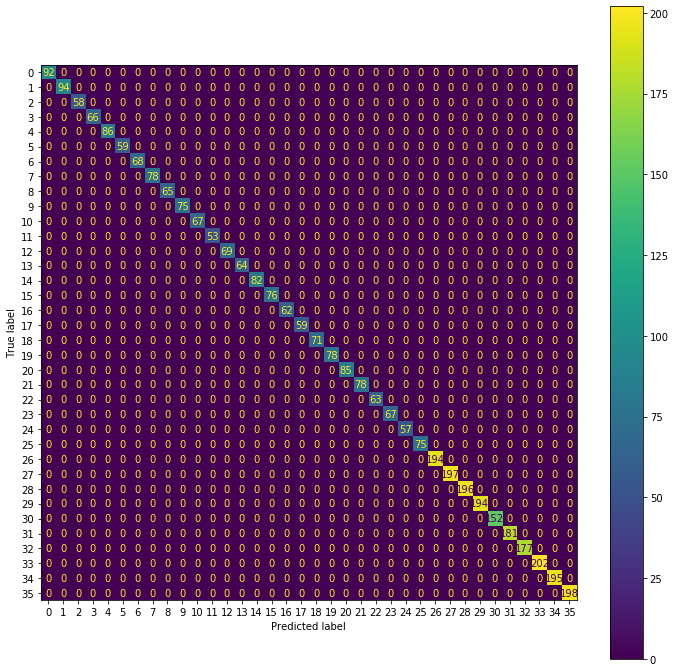

In [46]:
disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred)
fig = disp.figure_
fig.set_figwidth(12)
fig.set_figheight(12) 
plt.show()

# Getting Chars from Driving Data

In [19]:
# IMAGE_PATH = "/content/drive/MyDrive/ENPH 353/Competition/Plates/"
IMAGE_PATH = "../media/Plates/"
filenames = os.listdir(IMAGE_PATH)

filename_list = []
for filename in filenames:
    if os.path.isfile(os.path.join(IMAGE_PATH, filename)):
        filename_list.append(filename)

char_upper_hsv = np.array([121,255,255])
char_lower_hsv = np.array([118,38,88])

In [20]:
plates =[]
for filename in filename_list:
    image = cv2.imread(f"{IMAGE_PATH+filename}")
    #image = get_grayscale_image(filename)
    plates.append(image)

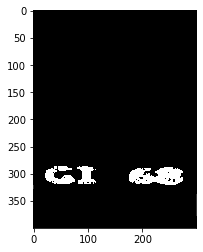

In [21]:
result = plates[0]
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
hsv_result = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
result_mask = cv2.inRange(hsv_result, char_lower_hsv, char_upper_hsv)
plt.imshow(result_mask, cmap='gray')
cv2.morphologyEx(result_mask, cv2.MORPH_OPEN, (5,5), result_mask, iterations=2)
plt.imshow(result_mask, cmap='gray')

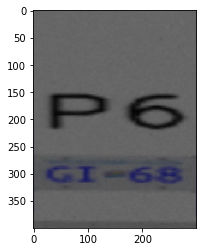

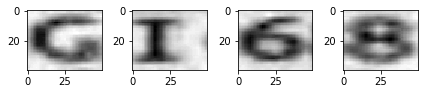

In [22]:
result = plates[0]
threshold = 120
hsv_result = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
result_mask = cv2.inRange(hsv_result, char_lower_hsv, char_upper_hsv)
cv2.morphologyEx(result_mask, cv2.MORPH_OPEN, (5,5), result_mask, iterations=2)
contours, _ = cv2.findContours(result_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
contours = sorted(contours, key=cv2.contourArea, reverse=True)

bounding_boxes = []
for c in contours:
                    if cv2.contourArea(c) > 300:
                        (x, y, w, h) = cv2.boundingRect(c)
                        #cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 255), 2)
                        bounding_boxes.append((x, y, w, h))
                        #total_area += w*h
# for c in contours:
#   if cv2.contourArea(c) < 5000 and cv2.contourArea(c) > 100:
#     cv2.drawContours(result, c, -1, (0, 255, 0), 3)
bounding_boxes.sort(key=lambda x: x[0], reverse=False)
chars = []

for box in bounding_boxes:
  if box[2] > 60:
    chars.append(cv2.cvtColor(result[box[1]-5: box[1]+35, box[0]: box[0]+50], cv2.COLOR_BGR2GRAY))
    chars.append(cv2.cvtColor(result[box[1]-5: box[1]+35, box[0]+box[2]//2: box[0]+box[2]//2+50], cv2.COLOR_BGR2GRAY))
    pass
  else:
    chars.append(cv2.cvtColor(result[box[1]-5: box[1]+35, box[0]: box[0]+50], cv2.COLOR_BGR2GRAY))


plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
# print(chars)

# Create a 2x2 subplot grid
fig, axs = plt.subplots(1, 4, figsize=(6, 6))
# Plot the smaller images in the remaining subplots
for i, ax in enumerate(axs.flatten()):
    ax.imshow(chars[i], cmap='gray')

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot

In [23]:
threshold = 120
def get_chars_from_image(filename):
  result = cv2.imread(f"{IMAGE_PATH+filename}")
  hsv_result = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
  result_mask = cv2.inRange(hsv_result, char_lower_hsv, char_upper_hsv)
  cv2.morphologyEx(result_mask, cv2.MORPH_OPEN, (5,5), result_mask, iterations=2)
  contours, _ = cv2.findContours(result_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)

  bounding_boxes = []
  for c in contours:
                      if cv2.contourArea(c) > 300:
                          (x, y, w, h) = cv2.boundingRect(c)
                          #cv2.rectangle(result, (x, y), (x + w, y + h), (0, 255, 255), 2)
                          bounding_boxes.append((x, y, w, h))
                          #total_area += w*h
  # for c in contours:
  #   if cv2.contourArea(c) < 5000 and cv2.contourArea(c) > 100:
  #     cv2.drawContours(result, c, -1, (0, 255, 0), 3)
  bounding_boxes.sort(key=lambda x: x[0], reverse=False)
  chars = []

  for box in bounding_boxes:
    if box[2] > 60:
      chars.append(cv2.cvtColor(result[box[1]: box[1]+40, box[0]: box[0]+50], cv2.COLOR_BGR2GRAY))
      chars.append(cv2.cvtColor(result[box[1]: box[1]+40, box[0]+box[2]//2: box[0]+box[2]//2+50], cv2.COLOR_BGR2GRAY))
      pass
    else:
      chars.append(cv2.cvtColor(result[box[1]: box[1]+40, box[0]: box[0]+50], cv2.COLOR_BGR2GRAY))
  return chars

In [66]:
def get_ID_from_image(filename):
  result = cv2.imread(f"{IMAGE_PATH+filename}")
  hsv_result = cv2.cvtColor(result, cv2.COLOR_BGR2HSV)
  result_mask = cv2.inRange(hsv_result, np.array([0,0,0]), np.array([0,0,70]))
  cv2.morphologyEx(result_mask, cv2.MORPH_OPEN, (5,5), result_mask, iterations=2)
  # plt.imshow(result_mask, cmap='gray')
  contours, _ = cv2.findContours(result_mask.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  contours = sorted(contours, key=cv2.contourArea, reverse=True)

  bounding_boxes = []
  for c in contours:
    if cv2.contourArea(c) > 300:
      (x, y, w, h) = cv2.boundingRect(c)
      bounding_boxes.append((x, y, w, h))
  bounding_boxes.sort(key=lambda x: x[0], reverse=False)
  if (len(bounding_boxes) == 2):
    return cv2.resize(cv2.cvtColor(result[bounding_boxes[1][1]-10: bounding_boxes[1][1]+70, bounding_boxes[1][0]-20: bounding_boxes[1][0]+130], cv2.COLOR_BGR2GRAY),(50,40))
  else:
    #throw an error
    raise Exception("No ID found")

In [53]:
print(filename_list[-1])
for filename in filename_list:
    try:
        id = get_ID_from_image(filename)
        # print(id)
    except(Exception):
        print(filename)
    # break

4_MV38__1681093928.8932703.jpg
2_JD83__1681093038.70224.jpg
8_BR55__1681093079.7535846.jpg
7_YZ79__1681094830.8931959.jpg
4_TR49__1681093056.0494153.jpg
6_XH11__1681093261.3705125.jpg
5_CE92__1681093933.2520108.jpg
3_DL13__1681093634.3554826.jpg
3_WJ95__1681095524.2843423.jpg
8_GS16__1681092746.570358.jpg
6_FV17__1681096167.2784307.jpg
2_XP29__1681093372.434283.jpg
6_MS53__1681095929.273276.jpg
7_IX58__1681095688.2075362.jpg
6_XW37__1681094419.5113726.jpg
4_GY20__1681095537.0730114.jpg
8_EA03__1681096266.0373616.jpg
3_BV15__1681096025.7256255.jpg
3_DL13__1681093632.9373014.jpg
2_WJ91__1681094250.9317117.jpg
7_SN86__1681093765.4632826.jpg
7_IJ25__1681095552.9213564.jpg
4_WB91__1681093253.308154.jpg
6_XH11__1681093397.946383.jpg
7_KQ00__1681094289.1938276.jpg
8_VD46__1681093773.0960083.jpg
4_ZI16__1681094609.1694534.jpg
7_IX58__1681095687.8708532.jpg


In [25]:
training_data = []
CLASSES = 36
for filename in filename_list:
    chars = get_chars_from_image(filename)
    if (len(chars) == 4 and chars[3].shape == (40, 50)): #needs to be more robust
      # training_data.append((chars[0], np.identity(CLASSES)[ord(filename[2])-65].reshape(CLASSES)))
      # training_data.append((chars[1], np.identity(CLASSES)[ord(filename[3])-65].reshape(CLASSES)))
      # training_data.append((chars[2], np.identity(CLASSES)[ord(filename[4])-48+26].reshape(CLASSES)))
      # training_data.append((chars[3], np.identity(CLASSES)[ord(filename[5])-48+26].reshape(CLASSES)))
      data.append((chars[0], np.identity(CLASSES)[ord(filename[2])-65].reshape(CLASSES)))
      data.append((chars[1], np.identity(CLASSES)[ord(filename[3])-65].reshape(CLASSES)))
      data.append((chars[2], np.identity(CLASSES)[ord(filename[4])-48+26].reshape(CLASSES)))
      data.append((chars[3], np.identity(CLASSES)[ord(filename[5])-48+26].reshape(CLASSES)))
      
      if chars[3].shape != (40, 50):
        print(filename)
    


In [61]:
training_data = []
CLASSES = 36
for filename in filename_list:
    try:
        id = get_ID_from_image(filename)
        data.append((id, np.identity(CLASSES)[ord(filename[0])-48+26].reshape(CLASSES)))
    except(Exception):
        print("Error")
        continue

# training_data.append(id_training_data)

Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error
Error


43786
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


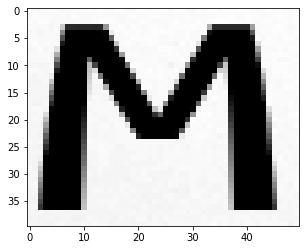

In [62]:
print(len(data))
plt.imshow(data[6][0], cmap='gray')
print(data[6][1])

In [32]:
# Shuffle the data
random.shuffle(data)

In [65]:
count = 0
for d in data:
    if d[0].shape != (40, 50):
        print(d[0].shape)
        count += 1
        # data.remove(d)

print(count)

(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(50, 40)
(

In [43]:
#Generate X and Y datasets
X_dataset = np.array([char[0] for char in data])

<ipython-input-43-163fdd673996>:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X_dataset = np.array([char[0] for char in data])


In [44]:
Y_dataset = np.array([state_pair[1] for state_pair in data])

In [75]:
cv2_imshow(X_dataset[200])
print(Y_dataset[200])

NameError: name 'cv2_imshow' is not defined

## Train on Real Data

In [35]:
VALIDATION_SPLIT = 0.1 # 10% of the dataset is for validation

split_index = math.ceil(X_dataset.shape[0] * (1-VALIDATION_SPLIT))

#splitting the datasets
X_train_dataset = X_dataset[:split_index]
Y_train_dataset = Y_dataset[:split_index]

X_val_dataset = X_dataset[split_index:]
Y_val_dataset = Y_dataset[split_index:]

# In this case we do not define a test set.

print("X shape: " + str(X_dataset.shape))
print("Y shape: " + str(Y_dataset.shape))
print("Total examples: {:d}\nTraining examples: {:d}\n"
      "Validation examples: {:d}".
      format(X_dataset.shape[0],
             X_train_dataset.shape[0],
             X_val_dataset.shape[0]))

X shape: (41883,)
Y shape: (41883, 36)
Total examples: 41883
Training examples: 37695
Validation examples: 4188


### Skip

In [37]:
#%tensorflow_version 2.9
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers

from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend

In [38]:
def reset_weights(model):
  for ix, layer in enumerate(model.layers):
      if (hasattr(model.layers[ix], 'kernel_initializer') and 
          hasattr(model.layers[ix], 'bias_initializer')):
          weight_initializer = model.layers[ix].kernel_initializer
          bias_initializer = model.layers[ix].bias_initializer

          old_weights, old_biases = model.layers[ix].get_weights()

          model.layers[ix].set_weights([
              weight_initializer(shape=old_weights.shape),
              bias_initializer(shape=len(old_biases))])

In [39]:
conv_model = models.Sequential()
conv_model.add(layers.Conv2D(32, (3, 3), activation='relu',
                             input_shape=(40, 50, 1))) #3 for bgr, 1 for grayscale 144, 256 for 20%
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(64, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
conv_model.add(layers.MaxPooling2D((2, 2)))
# conv_model.add(layers.Conv2D(128, (3, 3), activation='relu'))
# conv_model.add(layers.MaxPooling2D((2, 2)))
conv_model.add(layers.Flatten())
conv_model.add(layers.Dropout(0.5))
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(64, activation='relu'))
conv_model.add(layers.Dense(36, activation='softmax'))

In [40]:
conv_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 38, 48, 32)        320       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 19, 24, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 17, 22, 64)        18496     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 11, 64)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 6, 9, 128)         73856     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 3, 4, 128)       

In [41]:
LEARNING_RATE = 1e-4
conv_model.compile(loss='categorical_crossentropy',
                   optimizer=optimizers.RMSprop(learning_rate=LEARNING_RATE),
                   metrics=['acc'])

### end skip

In [42]:
history_conv = conv_model.fit(X_train_dataset, Y_train_dataset, 
                              validation_data=(X_val_dataset, Y_val_dataset), 
                              epochs=40, 
                              batch_size=16)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type numpy.ndarray).

## Verification of Model

In [92]:
from sklearn.metrics import ConfusionMatrixDisplay
ypred = conv_model.predict(X_dataset)
ypred=np.argmax(ypred, axis=1)
ytest=np.argmax(Y_dataset, axis=1)

118/118 [==============================] - 1s 12ms/step


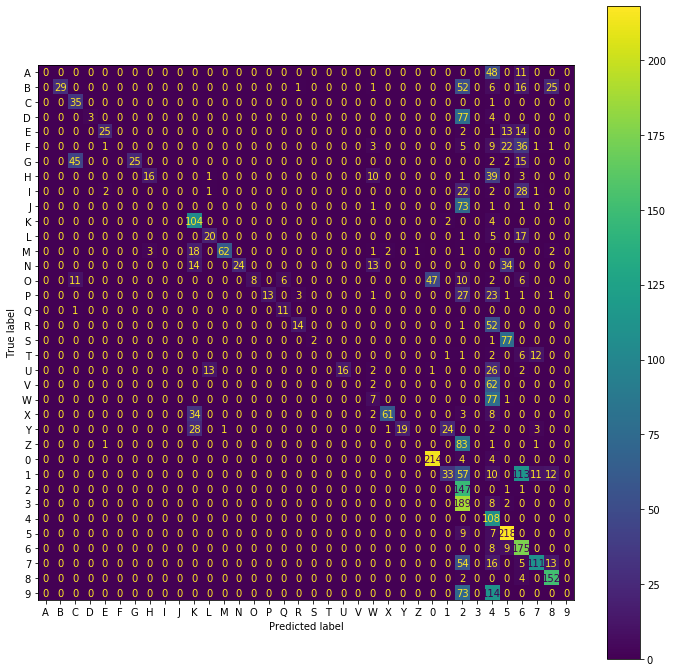

In [93]:
disp = ConfusionMatrixDisplay.from_predictions(ytest, ypred, labels=range(36) ,display_labels=[(chr(x+65),(chr(x+48-26)))[x>=26] for x in range(36)])
fig = disp.figure_
fig.set_figwidth(12)
fig.set_figheight(12) 
plt.show()

### Need more data of:
Plate:
I, S, Q, 5, 6, T, F, X, Y, L, P, E

ID:
2, 7

## Note:
Training on real data and then IDs is not a good idea.
Adding IDs to training data ruins accuracy. V3 will be horrible. Specifically with numbers but letters as well. 
Will try training on real data and IDs at the same time.

In [82]:
conv_model.save('Chars_model_V3.h5')

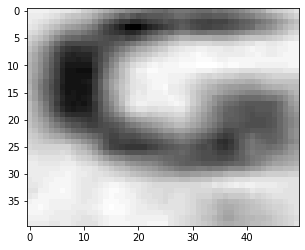

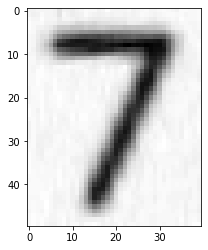

5
7


<ipython-input-81-371647ec7ab6>:17: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print((chr(x+65),(chr(x+48-26)))[x>=26])
<ipython-input-81-371647ec7ab6>:18: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  print((chr(y+65),(chr(y+48-26)))[y>=26])


In [81]:
id = 2
all_chars = []
all_ids = []
for filename in filename_list:
    all_chars.append(get_chars_from_image(filename))
    try:
        all_ids.append(get_ID_from_image(filename))
    except(Exception):
        pass

plt.imshow(all_chars[0][0], cmap='gray')
plt.show()
plt.imshow(all_ids[id], cmap='gray')
plt.show()
x = np.argmax(conv_model(all_chars[0][0].reshape(1, 40, 50, 1))[0])
y = np.argmax(conv_model(all_ids[id].reshape(1, 40, 50, 1))[0])
print((chr(x+65),(chr(x+48-26)))[x>=26])
print((chr(y+65),(chr(y+48-26)))[y>=26])